In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import numpy as np
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer

# Load "final_test_features.csv" data
csv_path = '/content/final_test_features.csv'  # Change this path
df_features = pd.read_csv(csv_path)

# Fill NaN values to handle missing data
df_features.fillna(0, inplace=True)

# Drop non-numeric columns for correlation calculation
non_numeric_cols = df_features.select_dtypes(exclude=['float64', 'int64']).columns
df_numeric = df_features.drop(columns=non_numeric_cols)

# Convert necessary columns to numeric, forcing errors to NaN
numeric_cols = ['url_length', 'domain_length', 'subdomain_count', 'path_length', 'risk_score', 'malicious_count']
for col in numeric_cols:
    df_features[col] = pd.to_numeric(df_features[col], errors='coerce')

# Fill NaN values again after conversion
df_features.fillna(0, inplace=True)


### URL Length Distribution

**Description:**  
This histogram illustrates the distribution of URL lengths, highlighting key differences between phishing and legitimate websites. The KDE overlay provides additional insight into the concentration of URL lengths.

**Key Insights:**  
- Phishing URLs often exhibit longer lengths, serving to obscure malicious content.  
- The histogram reveals a clustering of legitimate URLs at shorter lengths, with a long tail for suspiciously long URLs.  
- Outliers at extreme lengths may indicate potential phishing attempts and warrant further investigation.


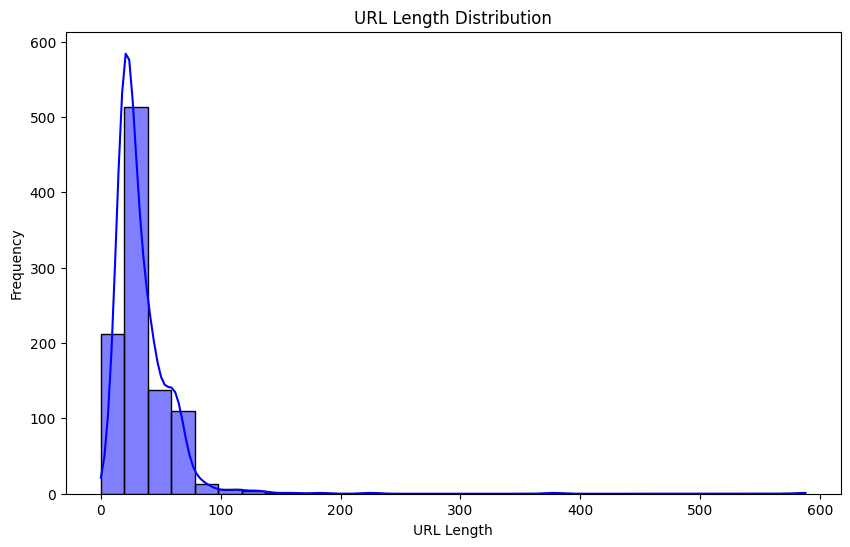

In [2]:
# Visualization 1. URL Length Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_features['url_length'], bins=30, kde=True, color='blue')
plt.title('URL Length Distribution')
plt.xlabel('URL Length')
plt.ylabel('Frequency')
plt.show()

### Domain Length by Label

**Description:**  
This boxplot compares the distribution of domain lengths for phishing (label = 1) and legitimate (label = 0) websites. It highlights variations in domain structure across the two categories.

**Key Insights:**  
- Phishing domains tend to exhibit slightly longer lengths compared to legitimate ones.  
- The presence of outliers suggests irregularities in domain naming, often associated with phishing attempts.  
- The median and interquartile range of domain lengths are similar for both labels, but phishing domains display a broader range of values.

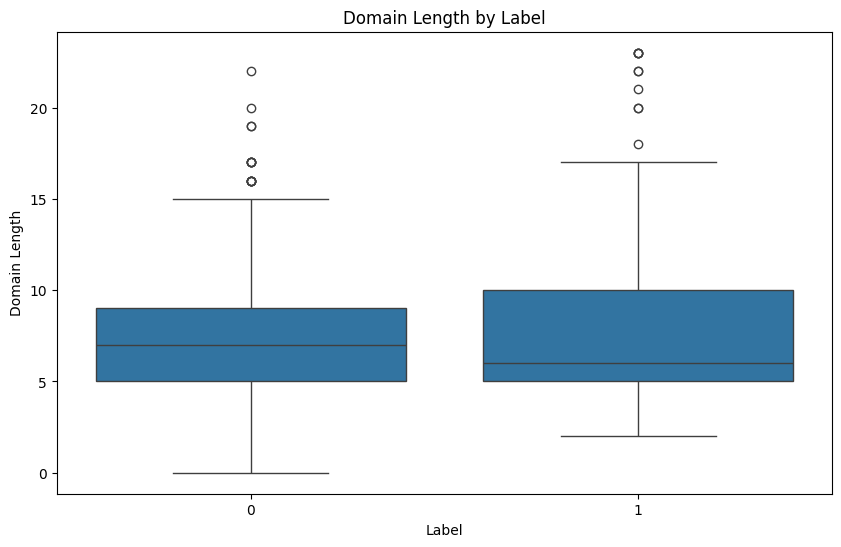

In [3]:
# Visualization 2. Domain Length by Label
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='domain_length', data=df_features)
plt.title('Domain Length by Label')
plt.xlabel('Label')
plt.ylabel('Domain Length')
plt.show()

### Path Length Distribution by Label

**Description:**  
This visualization shows the distribution of path lengths for phishing (orange) and legitimate (blue) URLs. The KDE overlay highlights the differences in density for each label.

**Key Insights:**  
- Phishing URLs tend to have longer path lengths compared to legitimate URLs, reflecting a strategy to embed additional misleading information.  
- The distribution of legitimate URLs is heavily concentrated at shorter path lengths, indicating a simpler structure.  
- The overlapping KDEs suggest some shared characteristics but with noticeable deviations at longer path lengths.


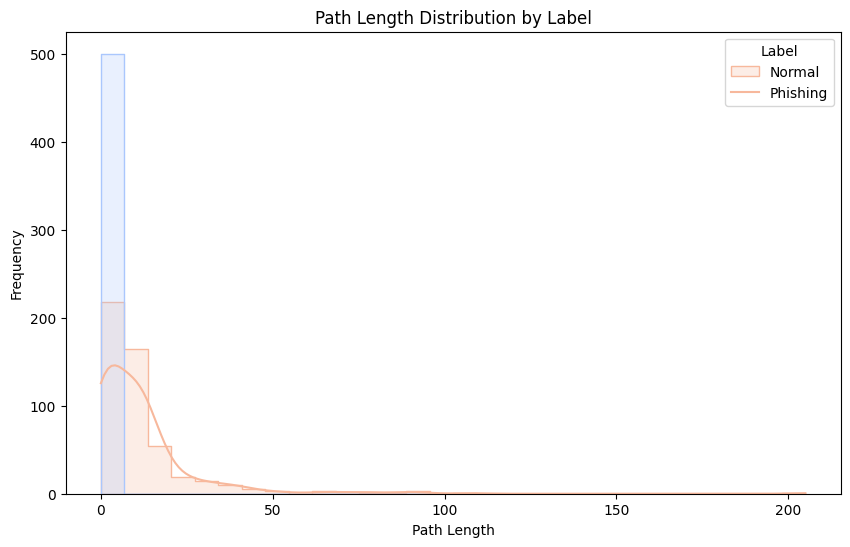

In [5]:
# Visualization 4. Path Length KDE by Label
plt.figure(figsize=(10, 6))
sns.histplot(df_features, x='path_length', hue='label', element='step', kde=True, palette='coolwarm', bins=30)
plt.title('Path Length Distribution by Label')
plt.xlabel('Path Length')
plt.ylabel('Frequency')
plt.legend(title='Label', labels=['Normal', 'Phishing'])
plt.show()

### WordCloud for Phishing and Normal URLs

**Description:**  
The WordClouds visualize the most frequent terms in phishing and normal URLs. The size of the words corresponds to their frequency, offering insights into the linguistic patterns of each category.

**Key Insights:**  
- **Phishing URLs:** Frequently include terms like "support," "login," and "secure," reflecting urgency and manipulation to deceive users.  
- **Normal URLs:** Feature terms like "github," "app," and "dev," emphasizing technical functionality and legitimate services.  
- The differences in vocabulary highlight the potential of textual analysis for distinguishing phishing URLs from legitimate ones.


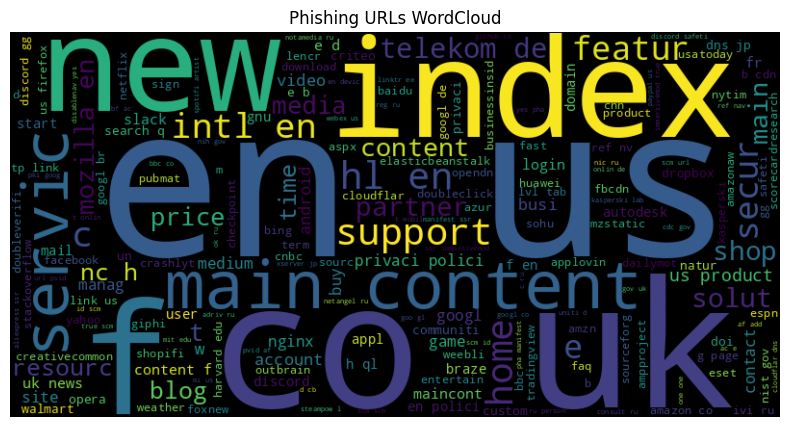

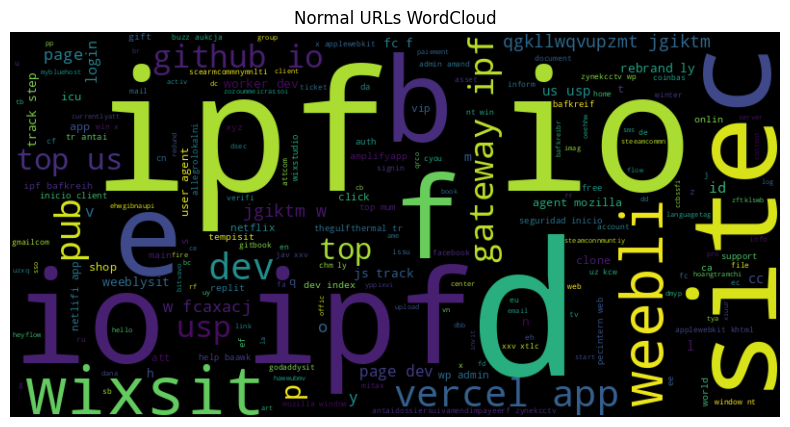

In [6]:
# Visualization 5. WordCloud for URLs
# Initialize tokenizer, stemmer, and stop words
tokenizer = RegexpTokenizer(r'[A-Za-z]+')
stemmer = SnowballStemmer("english")
stop_words = {"http", "https", "www", "com", "org", "net", "html", "php", "jsp"}

def process_url(url):
    tokens = tokenizer.tokenize(url)
    filtered = [word for word in tokens if word.lower() not in stop_words]
    return [stemmer.stem(word) for word in filtered]

# Load the "nlp_data.csv" data
csv_path = "/content/nlp_data.csv"  # Change this path
df_nlp = pd.read_csv(csv_path)

# Preprocess URLs
df_nlp['processed_url'] = df_nlp['url'].apply(lambda x: ' '.join(process_url(x)))

# Separate phishing and normal URLs
phishing_text = ' '.join(df_nlp[df_nlp['label'] == 1]['processed_url'])
normal_text = ' '.join(df_nlp[df_nlp['label'] == 0]['processed_url'])

# Generate WordClouds
# Phishing URLs WordCloud
phishing_wordcloud = WordCloud(width=800, height=400).generate(phishing_text)
plt.figure(figsize=(10, 5))
plt.imshow(phishing_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Phishing URLs WordCloud")
plt.show()

# Normal URLs WordCloud
normal_wordcloud = WordCloud(width=800, height=400).generate(normal_text)
plt.figure(figsize=(10, 5))
plt.imshow(normal_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Normal URLs WordCloud")
plt.show()

### Feature Correlation Heatmap

**Description:**  
This heatmap visualizes the correlation between numerical features in the dataset. Each cell represents the Pearson correlation coefficient, ranging from -1 (strong negative correlation) to 1 (strong positive correlation).

**Key Insights:**  
- **Highly Correlated Features:**  
   - `risk_score` and `malicious_count` show a strong positive correlation, highlighting their joint significance in identifying phishing URLs.  
   - `url_length` and `path_length` are moderately correlated, suggesting their shared relevance in URL structure analysis.  
- **Negative Correlations:**  
   - `domain_age_years` shows a strong negative correlation with phishing-related labels, indicating that newer domains are more likely to be associated with phishing attempts.  
- **Feature Importance:**  
   - The heatmap confirms the importance of features like `risk_score` and `malicious_count` in distinguishing phishing from legitimate websites.

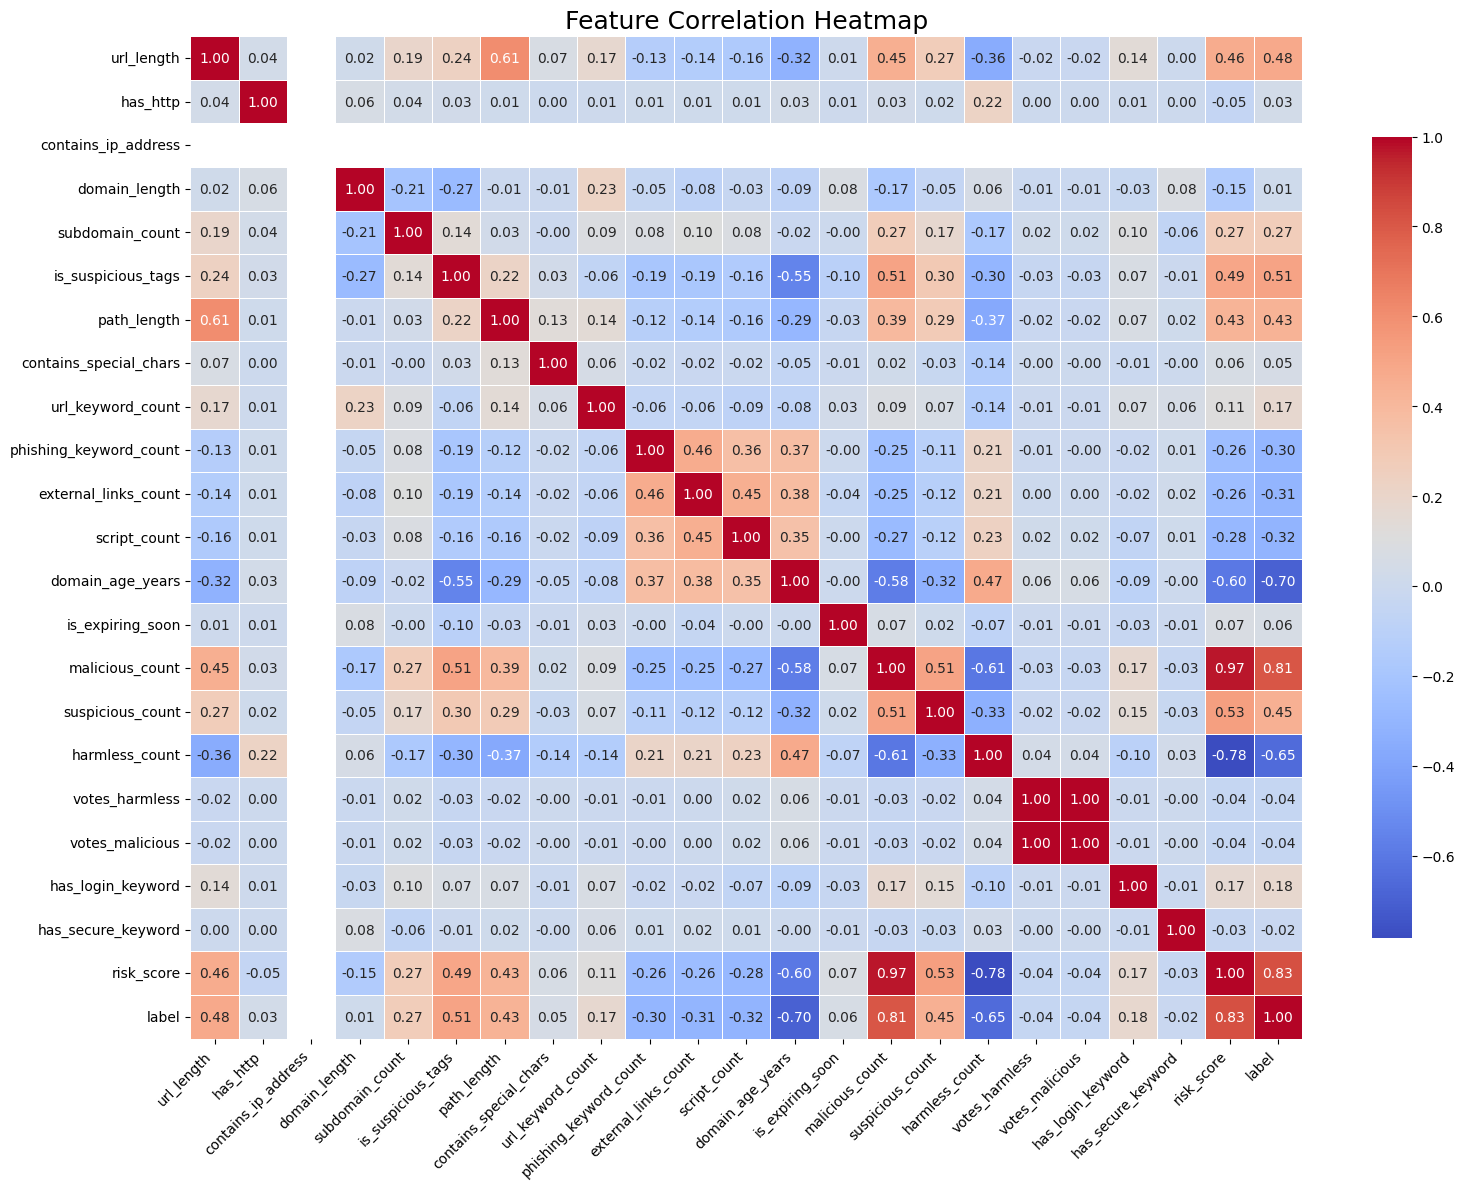

In [7]:
# Visualization 6. Feature Correlation Heatmap
plt.figure(figsize=(16, 12))
corr_matrix = df_numeric.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Heatmap', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

### Scatter Plot: URL Length vs. Domain Length by Label

**Description:**  
This scatter plot compares URL length and domain length, differentiated by labels (phishing = 1, legitimate = 0). The distribution reveals potential structural patterns distinguishing phishing URLs from legitimate ones.

**Key Insights:**  
- **Phishing URLs (orange):**  
   - Tend to exhibit greater variability in both URL and domain lengths, with some extreme values indicating potential attempts to obscure malicious content.  
- **Legitimate URLs (blue):**  
   - Concentrated in shorter lengths for both features, reflecting a simpler and more standardized structure.  
- **Clusters:**  
   - Overlapping clusters suggest some shared characteristics, but clear outliers in phishing URLs highlight key differences.

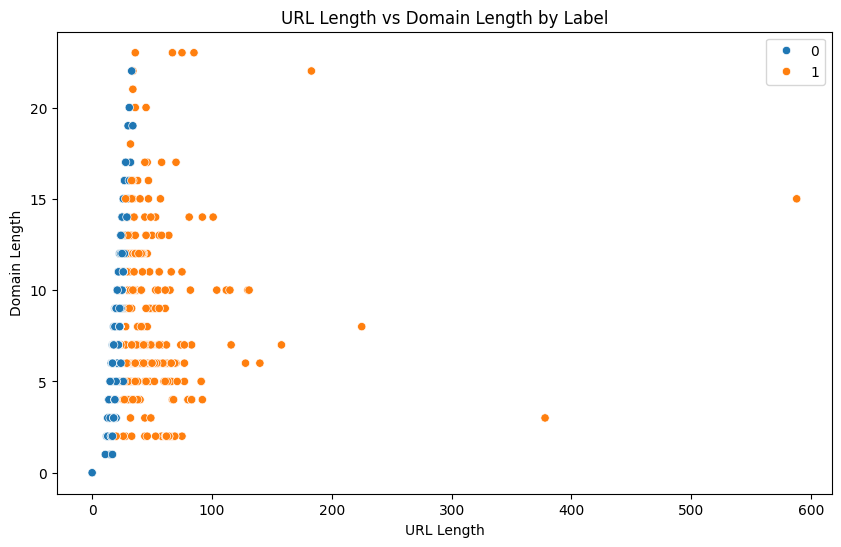

In [8]:
# Visualization 7. Scatter Plot - URL Length vs. Domain Length by Label
plt.figure(figsize=(10, 6))
sns.scatterplot(x='url_length', y='domain_length', hue='label', data=df_numeric)
plt.title('URL Length vs Domain Length by Label')
plt.xlabel('URL Length')
plt.ylabel('Domain Length')
plt.legend()
plt.show()

### Scatter Plots for Feature Pairs

**Description:**  
These scatter plots explore relationships between various feature pairs, with phishing (blue) and legitimate (orange) URLs distinguished by labels. Each plot provides insights into the correlations and distributions of selected features.

**Key Insights:**  

1. **URL Length vs. Domain Length:**  
   - Phishing URLs show higher variability, with extreme outliers in URL length.  
   - Legitimate URLs are more concentrated within shorter lengths for both features.  

2. **Subdomain Count vs. Path Length:**  
   - Phishing URLs tend to have fewer subdomains but show a wider range of path lengths.  
   - Legitimate URLs exhibit less variability in path length.  

3. **Risk Score vs. Malicious Count:**  
   - A strong positive correlation is observed between risk score and malicious count, particularly for phishing URLs.  
   - Legitimate URLs cluster near the lower end for both features, confirming their low risk and malicious count.

**Conclusion:**  
These visualizations highlight the significant structural and risk-based differences between phishing and legitimate URLs, supporting their utility in phishing detection models.

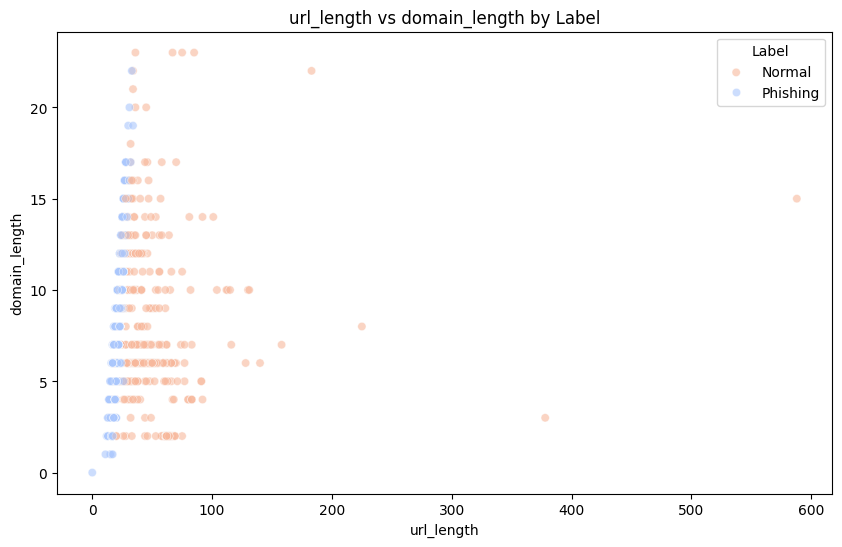

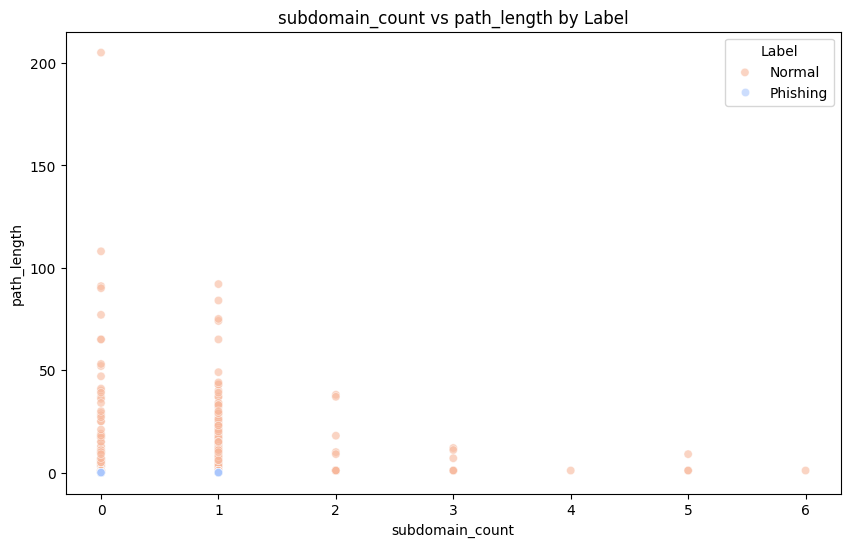

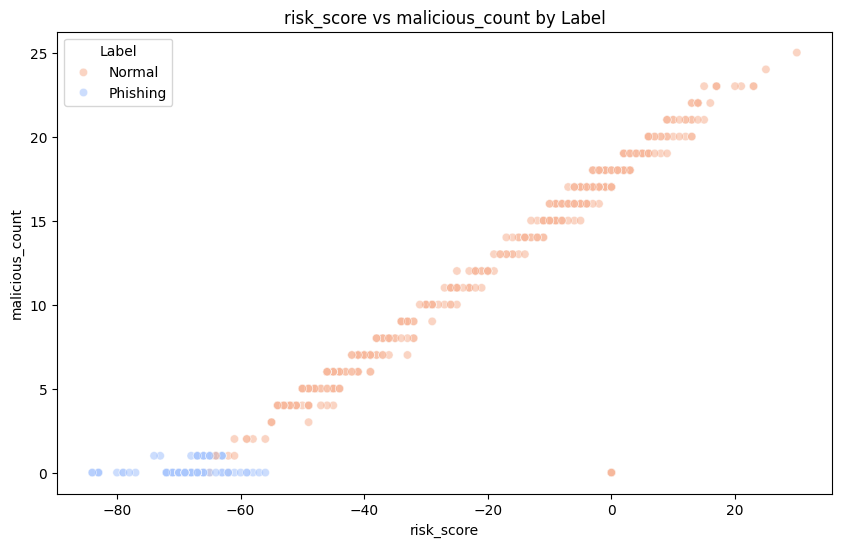

In [9]:
# Visualization 8. Scatter Plot for Other Feature Pairs
features_to_compare = [('url_length', 'domain_length'), ('subdomain_count', 'path_length'), ('risk_score', 'malicious_count')]
for feature_x, feature_y in features_to_compare:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=feature_x, y=feature_y, hue='label', data=df_numeric, palette='coolwarm', alpha=0.6)
    plt.title(f'{feature_x} vs {feature_y} by Label')
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.legend(title='Label', labels=['Normal', 'Phishing'])
    plt.show()

### Boxplot Comparisons for Key Features

**Description:**  
The boxplots compare the distribution of key numerical features between phishing (orange) and legitimate (blue) labels. They highlight central tendencies, spread, and outliers for each feature.

**Key Insights:**  

1. **Domain Length:**  
   - Phishing URLs exhibit greater variability and longer domain lengths with several outliers.  
   - Legitimate URLs tend to have shorter and more consistent domain lengths.

2. **Subdomain Count:**  
   - Phishing URLs show a higher occurrence of outliers with elevated subdomain counts, while legitimate URLs are tightly distributed around a lower count.  

3. **Risk Score:**  
   - Phishing URLs have significantly higher risk scores with a wider spread, reflecting their malicious nature.  
   - Legitimate URLs consistently maintain very low or negative risk scores.  

4. **Malicious Count:**  
   - Phishing URLs demonstrate a significantly higher malicious count, with values spanning a broader range.  
   - Legitimate URLs have near-zero malicious counts, reaffirming their safety.

**Conclusion:**  
These visualizations provide strong evidence for the distinct characteristics of phishing URLs compared to legitimate ones, reinforcing the importance of these features in classification and detection models.

<ipython-input-10-8621a02f69ca>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=feature, data=df_numeric, palette='coolwarm')


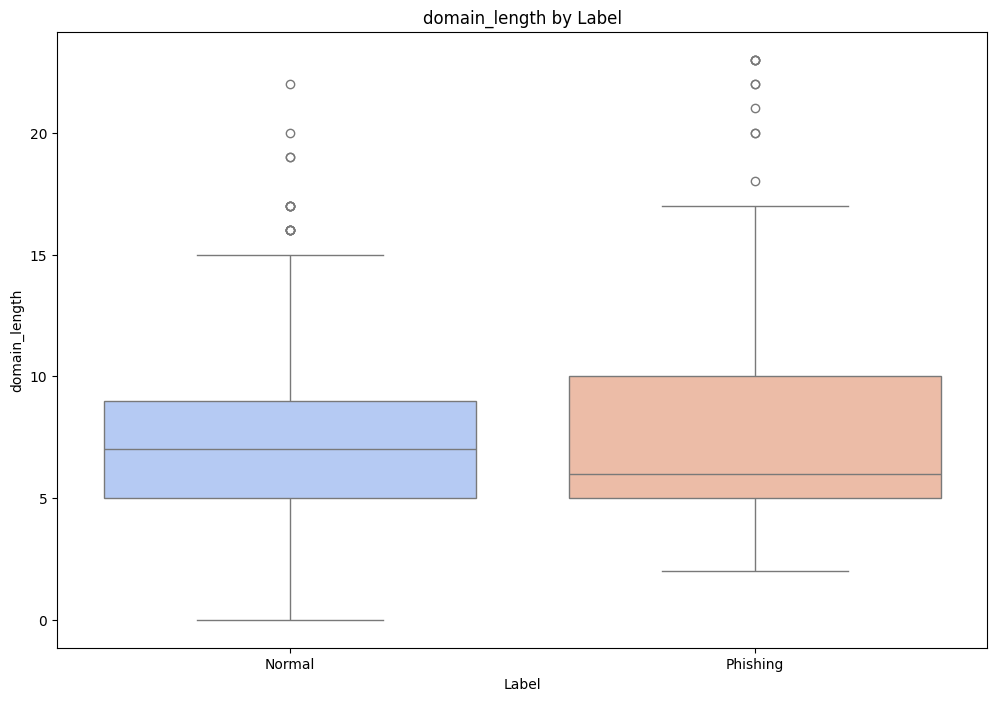

<ipython-input-10-8621a02f69ca>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=feature, data=df_numeric, palette='coolwarm')


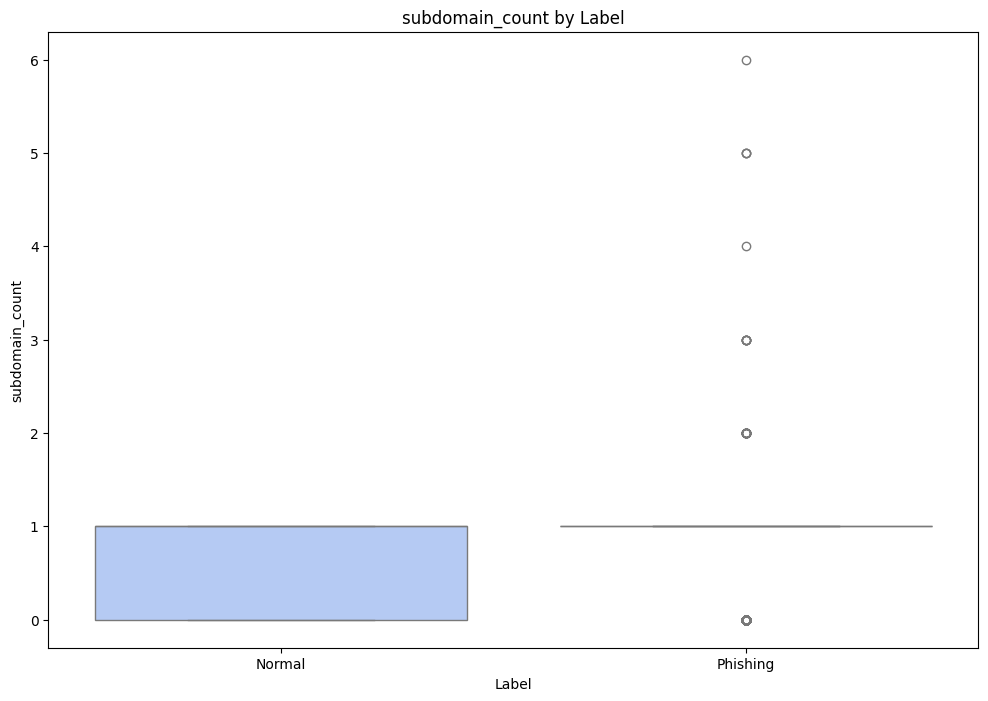

<ipython-input-10-8621a02f69ca>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=feature, data=df_numeric, palette='coolwarm')


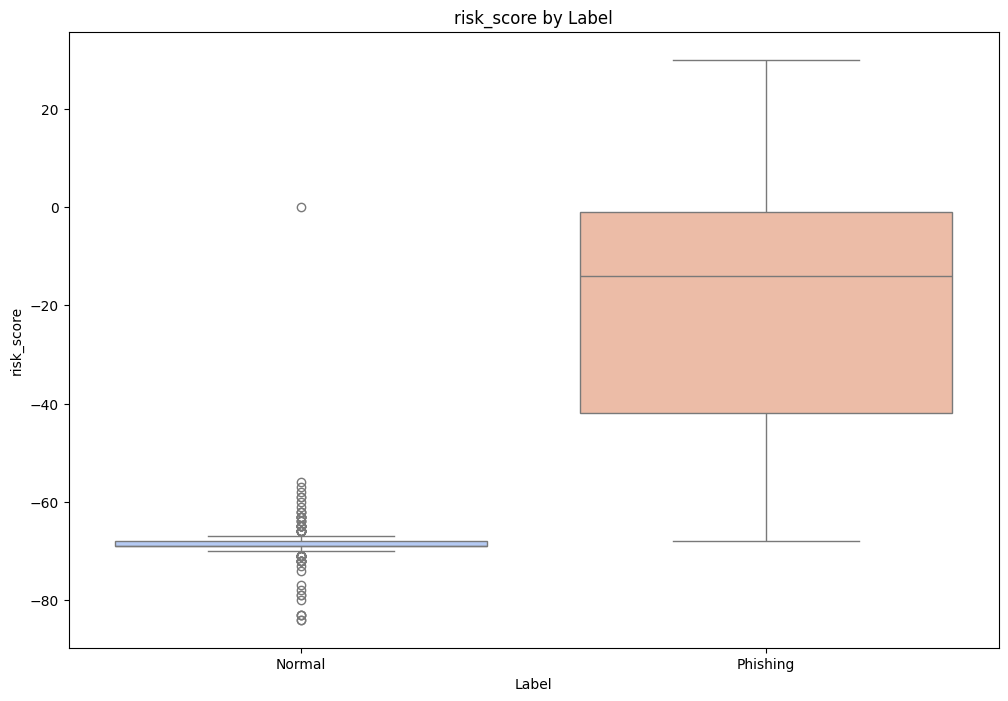

<ipython-input-10-8621a02f69ca>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=feature, data=df_numeric, palette='coolwarm')


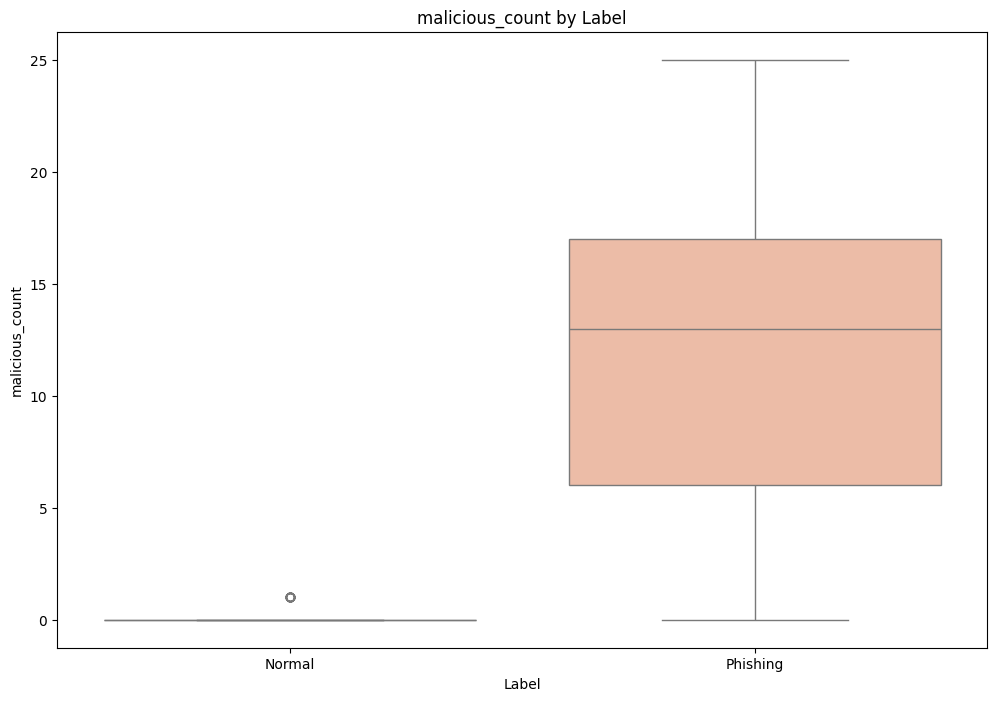

In [10]:
# Visualization 9. Boxplot Comparisons for Various Numeric Features
numeric_features = ['domain_length', 'subdomain_count', 'risk_score', 'malicious_count']
for feature in numeric_features:
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='label', y=feature, data=df_numeric, palette='coolwarm')
    plt.title(f'{feature} by Label')
    plt.xlabel('Label')
    plt.ylabel(feature)
    plt.xticks([0, 1], ['Normal', 'Phishing'])
    plt.show()

### Feature Importance from Random Forest

**Description:**  
This bar plot visualizes the importance of various features as determined by the Random Forest classifier. Features are ranked based on their contribution to the model's predictive power.

**Key Insights:**  
1. **Top Features:**  
   - `risk_score` and `path_length` are the most significant features, reflecting their critical role in identifying phishing URLs.  
   - `malicious_count` and `harmless_count` also have high importance, showcasing the model's reliance on threat-related metrics.

2. **Moderately Important Features:**  
   - Structural features like `url_length` and `domain_age_years` contribute meaningfully to the classification task.  
   - Behavioral indicators, such as `votes_harmless`, provide additional context for distinguishing between phishing and legitimate URLs.

3. **Least Important Features:**  
   - Features like `contains_ip_address`, `has_secure_keyword`, and `is_expiring_soon` have minimal impact, suggesting limited relevance in this dataset.

**Conclusion:**  
The feature importance plot underscores the value of combining structural, metadata-based, and behavioral features to enhance phishing detection accuracy.

<ipython-input-11-07174c69619c>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.values, y=feature_importances.index, palette='viridis')


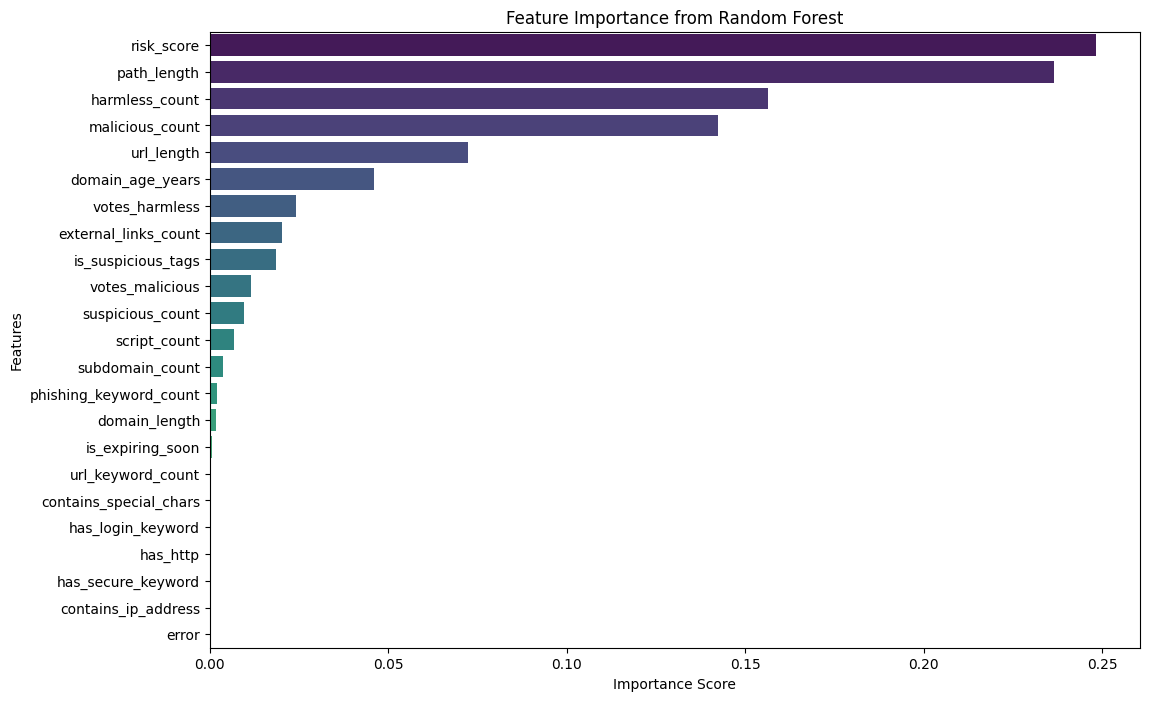

In [11]:
# Visualization 10. Feature Importance using Random Forest
# Split the data into features and labels
features = df_features.drop(columns=['url', 'label'])
labels = df_features['label']

# Instead of filtering, convert all columns to numeric with errors='coerce'
# and then fill NaN values with 0
for col in features.columns:
    features[col] = pd.to_numeric(features[col], errors='coerce')
features = features.fillna(0)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Feature Importance Plot
importances = model.feature_importances_
feature_names = features.columns
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances.values, y=feature_importances.index, palette='viridis')
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

### Cumulative Feature Importance Analysis

**Description:**  
This plot shows the cumulative importance of features as determined by the Random Forest classifier. It highlights how many features are required to achieve a specific cumulative importance threshold.

**Key Insights:**  
1. **95% Cumulative Importance Threshold:**  
   - The red dashed line represents the 95% cumulative importance threshold.  
   - The green dashed line indicates the number of features required to reach 95% of the total feature importance, emphasizing that only a subset of features is critical for effective classification.

2. **Feature Contribution:**  
   - The steep initial curve indicates that the most important features (e.g., `risk_score`, `path_length`, `malicious_count`) contribute significantly to the overall importance.  
   - Beyond approximately 10 features, the curve flattens, showing diminishing returns from adding less significant features.

**Conclusion:**  
This analysis suggests that using the top 10 features is sufficient to retain 95% of the model's predictive power, which can streamline the model and reduce complexity.

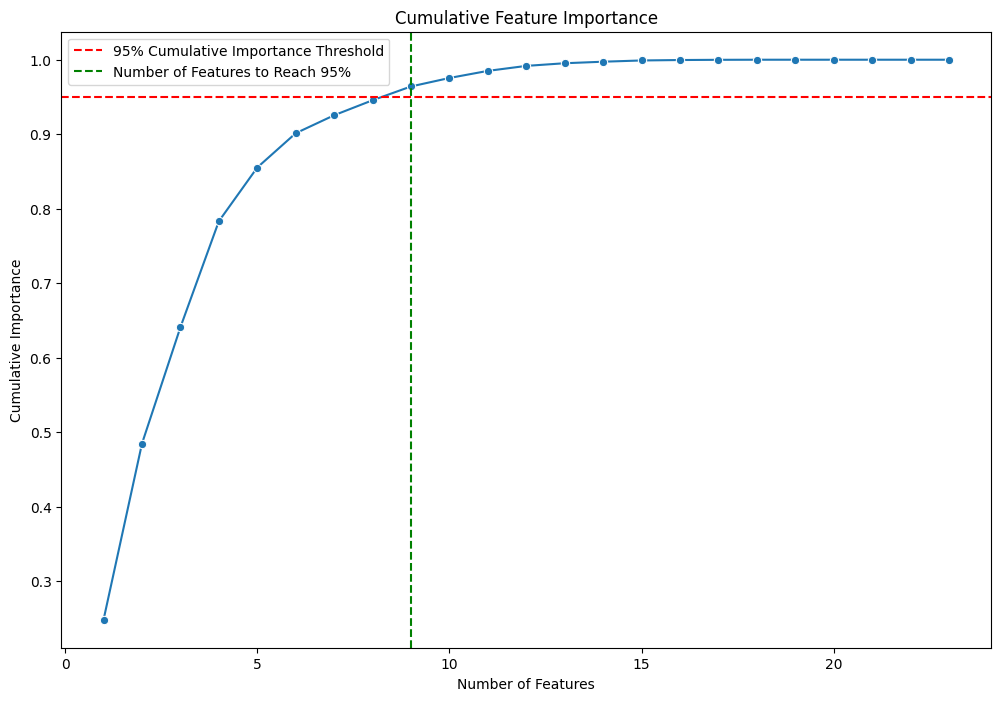

In [12]:
# Visualization 11. Cumulative Feature Importance Analysis
cumulative_importance = feature_importances.cumsum()

plt.figure(figsize=(12, 8))
sns.lineplot(x=np.arange(1, len(cumulative_importance) + 1), y=cumulative_importance, marker='o')
plt.title('Cumulative Feature Importance')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Cumulative Importance Threshold')
plt.axvline(x=len(cumulative_importance[cumulative_importance < 0.95]) + 1, color='g', linestyle='--', label='Number of Features to Reach 95%')
plt.legend()
plt.show()


### Distribution of Risk Scores

**Description:**  
This histogram illustrates the distribution of risk scores in the dataset, with a kernel density estimate (KDE) overlay to highlight the concentration of values.

**Key Insights:**  
1. **Phishing and Legitimate Separation:**  
   - The left peak (negative risk scores) corresponds to legitimate URLs, reflecting their low or harmless risk levels.  
   - The right tail (positive risk scores) represents phishing URLs, indicating higher associated risks.  

2. **Skewness:**  
   - The distribution is skewed towards lower risk scores, as the dataset contains a substantial proportion of legitimate URLs.  

3. **Outliers:**  
   - Outliers in the positive range suggest extreme risk levels for certain phishing URLs, which are critical for detection.

**Conclusion:**  
The risk score distribution underscores its importance as a feature for distinguishing between phishing and legitimate URLs.

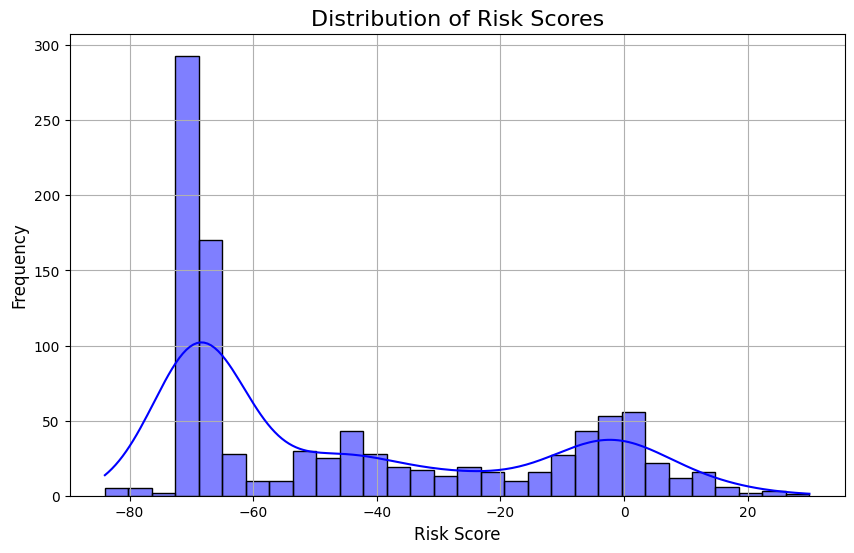

In [13]:
# Visualization 12: Distribution of Risk Scores
# Convert 'risk_score' and 'label' to numeric, handling errors
df_features['risk_score'] = pd.to_numeric(df_features['risk_score'], errors='coerce')
df_features['label'] = pd.to_numeric(df_features['label'], errors='coerce')

# Drop rows with missing values in 'risk_score', 'label', 'url_length'
data_cleaned = df_features.dropna(subset=['risk_score', 'label', 'url_length']) # Changed 'data' to 'df'


plt.figure(figsize=(10, 6))
sns.histplot(data_cleaned['risk_score'], bins=30, kde=True, color='blue')
plt.title('Distribution of Risk Scores', fontsize=16)
plt.xlabel('Risk Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()

### Boxplot of URL Length by Label

**Description:**  
This boxplot compares the distribution of URL lengths between phishing (label = 1) and legitimate (label = 0) URLs. It highlights the differences in their structural characteristics.

**Key Insights:**  
1. **Phishing URLs:**  
   - Have a significantly wider range of URL lengths, including extreme outliers.  
   - The median URL length is higher compared to legitimate URLs, indicating longer and more complex phishing URLs.

2. **Legitimate URLs:**  
   - Display a more compact range of URL lengths, with fewer outliers.  
   - Their simpler structure reflects the standardized nature of legitimate websites.

3. **Outliers:**  
   - Extreme outliers in phishing URLs may represent deliberate attempts to mask malicious intent.

**Conclusion:**  
The distinction in URL length distribution highlights its relevance as a feature for differentiating phishing from legitimate URLs in detection models.

<ipython-input-14-fa94fa7e29dc>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='url_length', data=data_cleaned, palette='Set2')


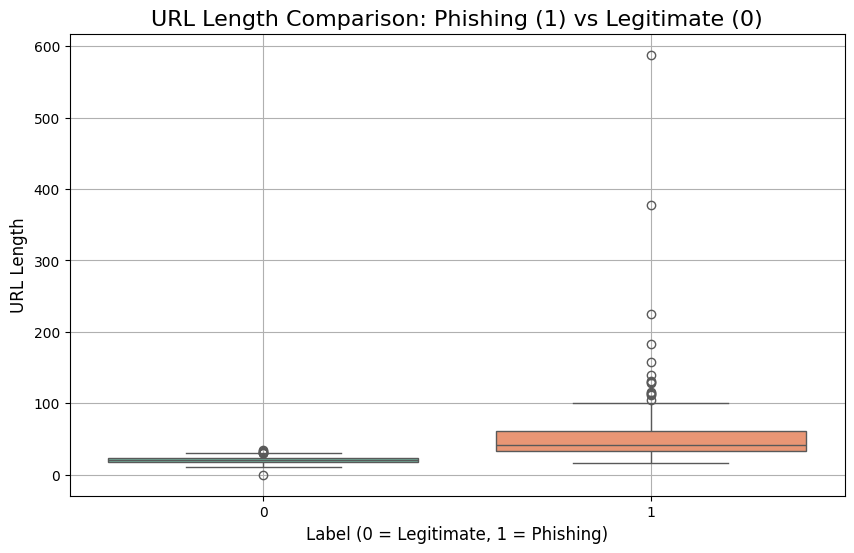

In [14]:
# Visualization 13: Boxplot of URL Length by Label
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='url_length', data=data_cleaned, palette='Set2')
plt.title('URL Length Comparison: Phishing (1) vs Legitimate (0)', fontsize=16)
plt.xlabel('Label (0 = Legitimate, 1 = Phishing)', fontsize=12)
plt.ylabel('URL Length', fontsize=12)
plt.grid(True)
plt.show()

### Feature Count Comparison

**Description:**  
This barplot compares the count of two binary features, `has_http` and `contains_ip_address`, across the dataset. It visualizes the frequency of these characteristics in the URLs.

**Key Insights:**  
1. **`has_http`:**  
   - Nearly all URLs in the dataset contain the `http` protocol, highlighting its ubiquity in both phishing and legitimate websites.  

2. **`contains_ip_address`:**  
   - Very few URLs contain IP addresses, indicating that this feature is relatively rare in both phishing and legitimate URLs. However, its presence may signal suspicious activity.

**Conclusion:**  
The visualization suggests that while `has_http` is a common feature, `contains_ip_address` can act as a discriminative feature, albeit with limited occurrence.

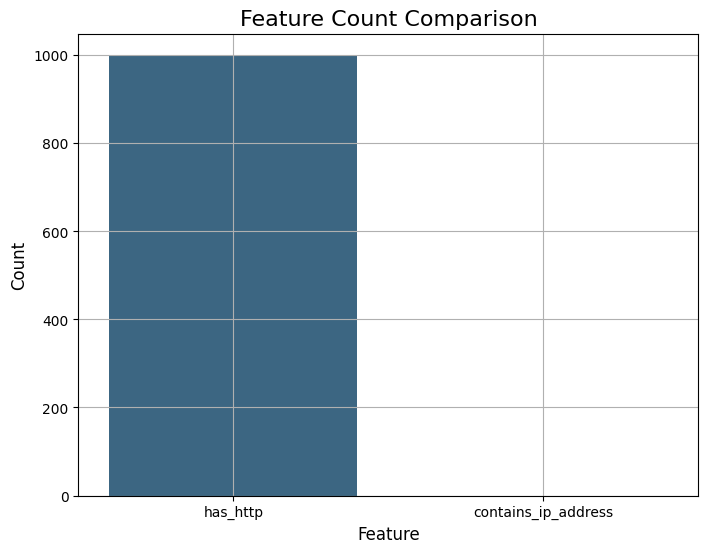

In [15]:
# Visualization 14: Feature Count Comparison (Barplot)
feature_counts = data_cleaned[['has_http', 'contains_ip_address']].sum().reset_index()
feature_counts.columns = ['Feature', 'Count']
plt.figure(figsize=(8, 6))
sns.barplot(x='Feature', y='Count', data=feature_counts, hue='Feature', dodge=False, palette='viridis')
plt.title('Feature Count Comparison', fontsize=16)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(True)
plt.show()

### Scatter Plot: URL Length vs. Risk Score with Labels

**Description:**  
This scatter plot examines the relationship between URL length and risk score, with phishing (label = 1) and legitimate (label = 0) URLs distinguished by color.

**Key Insights:**  
1. **Phishing URLs (Purple):**  
   - Exhibit a wide range of URL lengths and higher risk scores.  
   - Some outliers show extreme URL lengths combined with high-risk scores, signaling malicious intent.

2. **Legitimate URLs (Blue):**  
   - Cluster around shorter URL lengths with consistently lower or negative risk scores, reflecting their safer nature.  

3. **Separation:**  
   - The distinction between clusters demonstrates that risk score and URL length are effective features for differentiating phishing from legitimate URLs.

**Conclusion:**  
This visualization reinforces the combined significance of URL length and risk score in phishing detection, showcasing their predictive value.

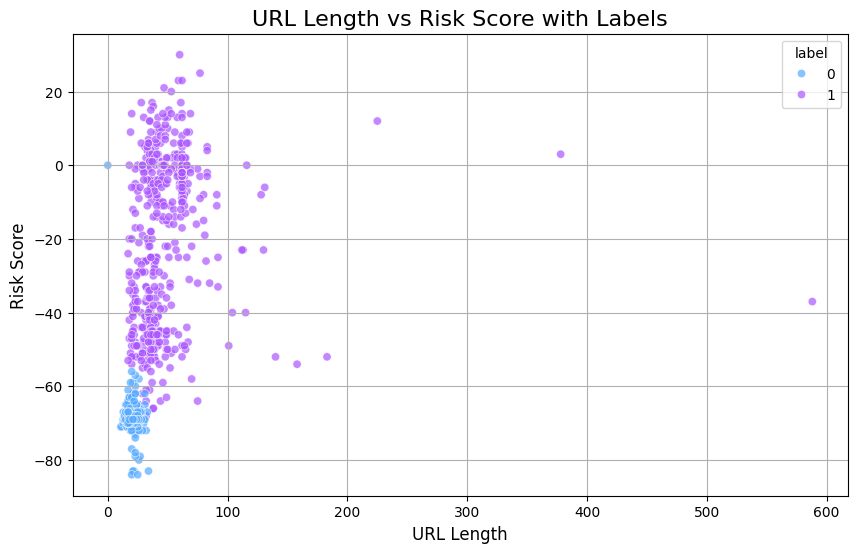

In [16]:
# Visualization 15: Scatter Plot of URL Length vs Risk Score
plt.figure(figsize=(10, 6))
sns.scatterplot(x='url_length', y='risk_score', hue='label', data=data_cleaned, palette='cool', alpha=0.7, edgecolor='w', linewidth=0.5)
plt.title('URL Length vs Risk Score with Labels', fontsize=16)
plt.xlabel('URL Length', fontsize=12)
plt.ylabel('Risk Score', fontsize=12)
plt.grid(True)
plt.show()

### Pie Chart: Proportion of Legitimate vs. Phishing URLs

**Description:**  
This pie chart illustrates the distribution of legitimate (label = 0) and phishing (label = 1) URLs in the dataset.

**Key Insights:**  
- The dataset is balanced, with **50% phishing URLs** (red) and **50% legitimate URLs** (green).  
- This equal distribution ensures that machine learning models trained on the dataset are not biased toward either label.

**Conclusion:**  
The balanced nature of the dataset supports fair and unbiased classification, enhancing the reliability of the model's performance evaluation.

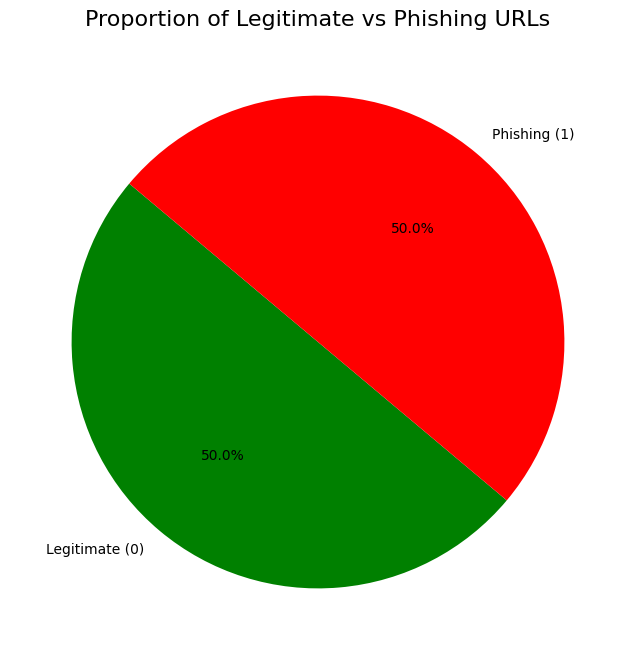

In [17]:
# Visualization 16: Pie Chart of Labels
plt.figure(figsize=(8, 8))
label_counts = data_cleaned['label'].value_counts()

# Check if label_counts is empty and handle accordingly
if label_counts.empty:
    print("Warning: No data for pie chart. 'data_cleaned' might be empty.")
else:
    plt.pie(label_counts, labels=['Legitimate (0)', 'Phishing (1)'],
            autopct='%1.1f%%', startangle=140, colors=['green', 'red'])
    plt.title('Proportion of Legitimate vs Phishing URLs', fontsize=16)
    plt.show()

### Hexbin Plot: URL Length vs. Risk Score

**Description:**  
This hexbin plot shows the density of data points in the relationship between URL length and risk score. The color intensity represents the logarithmic density of points within each hexagonal bin.

**Key Insights:**  
1. **High-Density Regions:**  
   - Most legitimate URLs cluster around shorter URL lengths (below 100) with lower or negative risk scores.  
   - A dense cluster is visible at URL lengths under 50 with risk scores below -40, representing a safe and legitimate subset.  

2. **Phishing Patterns:**  
   - Points with higher risk scores (above 0) are more scattered and exhibit greater variability in URL length, indicating potential phishing URLs.  
   - Outliers with extreme URL lengths and high risk scores are clear indicators of malicious intent.

3. **Logarithmic Density:**  
   - The log scale highlights both the high-density regions for legitimate URLs and the sparse distribution of phishing outliers.

**Conclusion:**  
This plot visually reinforces the distinct separation between legitimate and phishing URLs, emphasizing the importance of risk score and URL length as differentiating features.

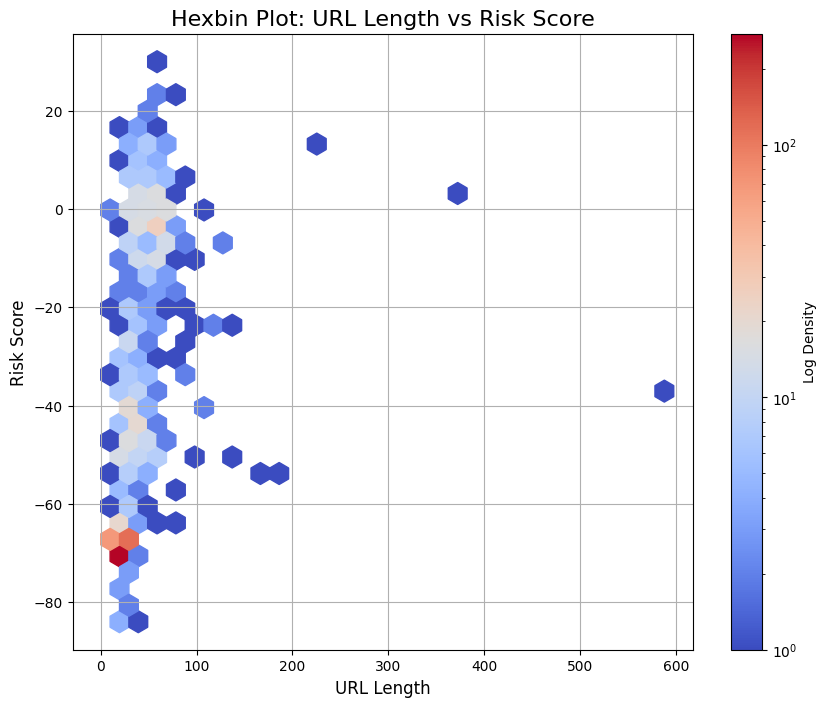

In [18]:
# Visualization 17: Hexbin Plot of URL Length vs Risk Score
plt.figure(figsize=(10, 8))
hexbin_plot = plt.hexbin(
    x=data_cleaned['url_length'],
    y=data_cleaned['risk_score'],
    gridsize=30,
    cmap='coolwarm',
    bins='log',
    mincnt=1  # Avoid invalid vmin/vmax by ensuring a minimum count
)
plt.title('Hexbin Plot: URL Length vs Risk Score', fontsize=16)
plt.xlabel('URL Length', fontsize=12)
plt.ylabel('Risk Score', fontsize=12)
cb = plt.colorbar(hexbin_plot, label='Log Density')
plt.grid(True)
plt.show()

### Histogram of Risk Scores by Label

**Description:**  
This histogram compares the distribution of risk scores for legitimate (label = 0) and phishing (label = 1) URLs. Each label is represented with a separate color for clarity.

**Key Insights:**  
1. **Legitimate URLs (Label 0):**  
   - Highly concentrated around low or negative risk scores, with a distinct peak at approximately -80.  
   - Reflects the consistent and safe nature of legitimate URLs.

2. **Phishing URLs (Label 1):**  
   - Spread across a wider range of risk scores, with a gradual increase toward positive scores.  
   - This indicates more variability in phishing risk levels, with higher values corresponding to greater suspicion.

3. **Separation:**  
   - The clear difference in distributions reinforces the effectiveness of risk score as a feature for classification.

**Conclusion:**  
The histogram highlights the stark contrast in risk score patterns between phishing and legitimate URLs, making it a reliable metric for detection models.

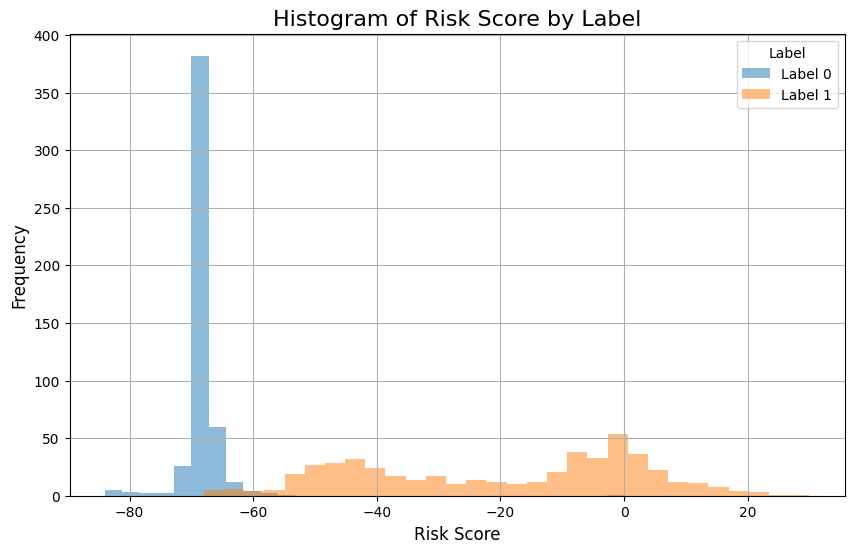

In [19]:
# Visualization 18: Histogram of Risk Scores by Label
plt.figure(figsize=(10, 6))
for label in [0, 1]:
    subset = data_cleaned[data_cleaned['label'] == label]
    plt.hist(subset['risk_score'], bins=30, alpha=0.5, label=f'Label {label}')
plt.title('Histogram of Risk Score by Label', fontsize=16)
plt.xlabel('Risk Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Label')
plt.grid(True)
plt.show()

### Violin Plot: Domain Length by Label

**Description:**  
This violin plot compares the distribution of domain lengths between legitimate (label = 0) and phishing (label = 1) URLs, visualizing density and quartiles.

**Key Insights:**  
1. **Legitimate URLs (Label 0):**  
   - Domain lengths are more tightly clustered, with a peak density around shorter values (approximately 5–10).  
   - Reflects the simpler and standardized structure of legitimate URLs.

2. **Phishing URLs (Label 1):**  
   - Exhibits a broader range of domain lengths with higher variability.  
   - The distribution shows an extended tail, indicating some phishing URLs use much longer domain lengths.

3. **Quartiles:**  
   - The inner quartiles of phishing URLs span a wider range than those of legitimate URLs, highlighting their inconsistency.

**Conclusion:**  
This visualization underscores the variability of phishing URL structures compared to the more uniform nature of legitimate URLs, making domain length a valuable feature for classification.

<ipython-input-20-736bf7759c27>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='label', y='domain_length', data=data_cleaned, scale='count', inner='quartile', palette='muted')
<ipython-input-20-736bf7759c27>:3: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(x='label', y='domain_length', data=data_cleaned, scale='count', inner='quartile', palette='muted')


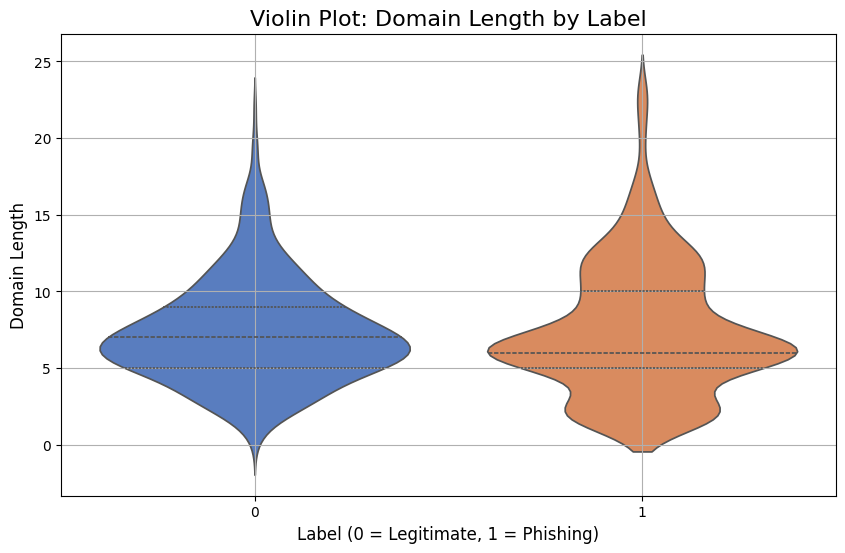

In [20]:
# Visualization 19: Violin Plot of Domain Length by Label
plt.figure(figsize=(10, 6))
sns.violinplot(x='label', y='domain_length', data=data_cleaned, scale='count', inner='quartile', palette='muted')
plt.title('Violin Plot: Domain Length by Label', fontsize=16)
plt.xlabel('Label (0 = Legitimate, 1 = Phishing)', fontsize=12)
plt.ylabel('Domain Length', fontsize=12)
plt.grid(True)
plt.show()

### Heatmap: Feature Averages by Label

**Description:**  
This heatmap visualizes the average values of numeric features for legitimate (label = 0) and phishing (label = 1) URLs. The color intensity represents the magnitude of the averages.

**Key Insights:**  
1. **Phishing URLs (Label = 1):**  
   - Features like `url_length`, `path_length`, and `malicious_count` are significantly higher compared to legitimate URLs, reflecting their complexity and suspicious nature.  
   - Lower values for `domain_age_years` highlight that phishing domains are often newer.

2. **Legitimate URLs (Label = 0):**  
   - Higher values for `harmless_count` and `votes_harmless` underscore their safe and trustworthy nature.  
   - `risk_score` is much lower, aligning with their low-risk profile.

3. **Distinct Features:**  
   - Features such as `external_links_count` and `phishing_keyword_count` show clear differences, making them reliable indicators for classification.

**Conclusion:**  
The heatmap emphasizes the contrasting patterns in feature averages, showcasing their effectiveness in distinguishing phishing from legitimate URLs.

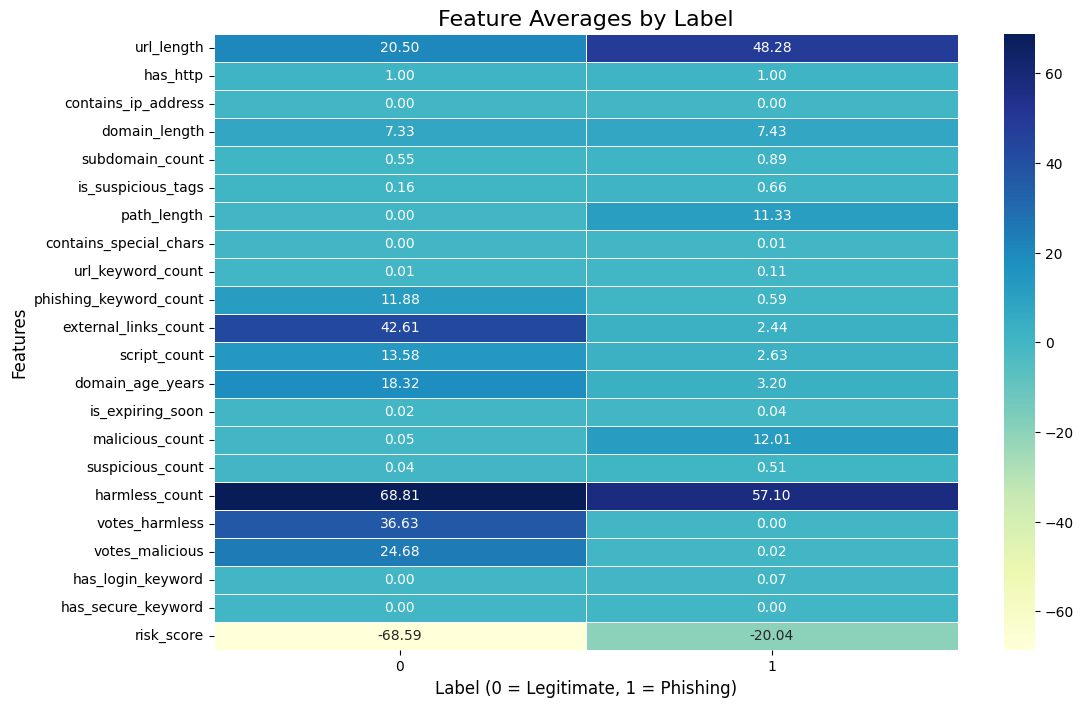

In [21]:
# Visualization 20: Heatmap of Feature Interactions by Label
plt.figure(figsize=(12, 8))
# Select only numeric features for groupby and mean calculation
label_grouped = data_cleaned.select_dtypes(include=['number']).groupby('label').mean()
sns.heatmap(label_grouped.T, annot=True, cmap='YlGnBu', fmt='.2f', cbar=True, linewidths=0.5)
plt.title('Feature Averages by Label', fontsize=16)
plt.xlabel('Label (0 = Legitimate, 1 = Phishing)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()

### Feature Importance Based on Correlation with Label

**Description:**  
This bar plot ranks features by their correlation with the label (phishing vs. legitimate). Positive correlations indicate higher importance in identifying phishing URLs, while negative correlations suggest relevance to legitimate URLs.

**Key Insights:**  
1. **Top Positive Correlations (Phishing Indicators):**  
   - `risk_score` and `malicious_count` have the highest positive correlations, making them critical for detecting phishing URLs.  
   - Features like `is_suspicious_tags` and `url_length` further contribute to phishing identification.

2. **Top Negative Correlations (Legitimacy Indicators):**  
   - Features such as `contains_ip_address`, `domain_age_years`, and `harmless_count` are strongly negatively correlated, highlighting their association with legitimate URLs.  

3. **Lesser Contributing Features:**  
   - Features like `has_secure_keyword` and `contains_special_chars` show minimal correlation, suggesting limited predictive value.

**Conclusion:**  
This plot highlights the most relevant features for distinguishing phishing from legitimate URLs, providing valuable insights for model optimization.

<ipython-input-22-9be890fca6f3>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance.values, y=feature_importance.index, palette='viridis')


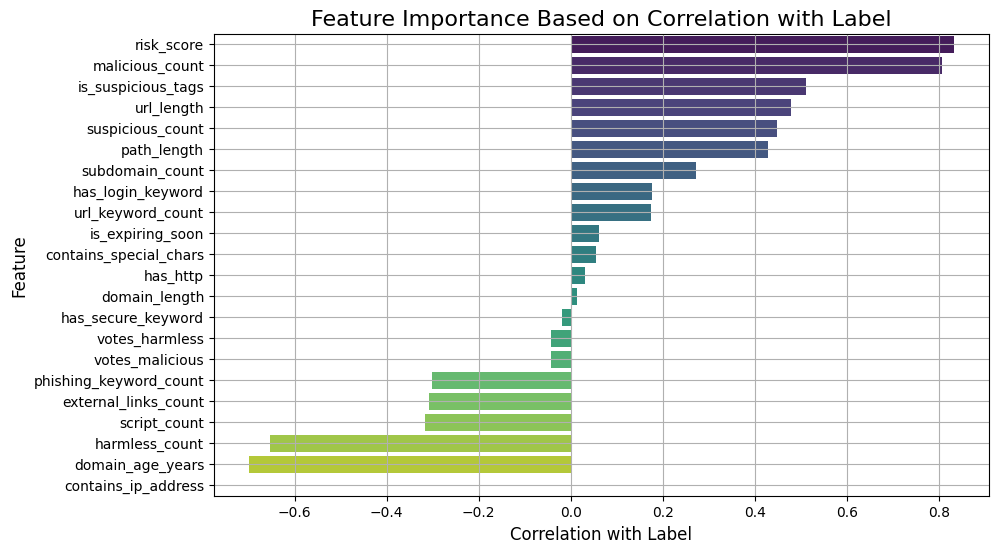

In [22]:
# Visualization 21: Feature Importance Bar Plot
# Select only numeric features for correlation calculation
numerical_features = data_cleaned.select_dtypes(include=['number'])
feature_importance = numerical_features.corr()['label'].sort_values(ascending=False).drop('label')
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.values, y=feature_importance.index, palette='viridis')
plt.title('Feature Importance Based on Correlation with Label', fontsize=16)
plt.xlabel('Correlation with Label', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(True)
plt.show()